# 1. Batch Normalization

## 1.1 Reference
- https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Batch_Normalization_Evaluation_(with_Residual_Connection).ipynb
- https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
- paper : https://arxiv.org/abs/1502.03167

## 1.2 Introduction

ResNet18 모델을 이용하여 Batch Normalization의 성능을 측정한다.  
- CIFAR-10 데이터를 이용하여 성능을 측정
- Batch Normalization layer의 사용 여부를 설정하여 성능 측정

# 2. Library Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

# 3. ResNet Model Define

## 3.1 Basic Block Class Define

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, with_BN, stride = 1):
        super(BasicBlock, self).__init__()
        self.with_BN = with_BN
        
        # 3 by 3 filter
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size = 3, stride = stride,
                               padding = 1, bias = False)
        if with_BN:
            self.bn1 = nn.BatchNorm2d(planes)
        
        # 3 by 3 filter
        self.conv2 = nn.Conv2d(planes, planes, 
                               kernel_size = 3, stride = 1, 
                               padding = 1, bias = False)
        if with_BN:
            self.bn2 = nn.BatchNorm2d(planes)
            
        # 단순한 identity mapping 인 경우
        self.shortcut = nn.Sequential()
        # 단순한 identity mapping 아닌 경우
        if stride != 1:
            modules = [nn.Conv2d(in_planes, planes,
                                  kernel_size = 1, stride = stride,
                                  bias = False)]
            if with_BN:
                modules.append(nn.BatchNorm2d(planes))
            self.shortcut = nn.Sequential(*modules)
            
    def forward(self, x):
        if self.with_BN:
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        # ** skip connection !!!! **
        out += self.shortcut(x)
        out = F.relu(out)
        return out

## 3.2 ResNet Define

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, with_BN, num_classes = 10):
        super(ResNet, self).__init__()
        
        self.in_planes = 64
        self.with_BN = with_BN
        
        # 64개의 3 by 3 filter 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, 
                               stride = 1, padding = 1,
                               bias = False)
        if with_BN:
            self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, with_BN, 
                                       num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, with_BN, 
                                       num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, with_BN, 
                                       num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, with_BN, 
                                       num_blocks[3], stride = 2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, with_BN, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            # 다음 레이어를 위해 채널 수 변경
            self.in_planes = planes 
        return nn.Sequential(*layers)
    
    def forward(self, x):
        if self.with_BN:
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## 3.3 ResNet-18 Define

In [4]:
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

# 4. DataSet Loader

In [5]:
transform_train = transforms.Compose([transforms.RandomCrop(32, padding = 4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
                                     ])
transform_test = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                             download = True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                             download = True, transform = transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128,
                                           shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100,
                                           shuffle = False, num_workers = 4)

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 5. Train and Test Function Define

## 5.1 Loss Function

In [6]:
criterion = nn.CrossEntropyLoss()

## 5.2 Train Function

In [7]:
def train(net, optimizer, epoch, step, cuda):
    net.train()
    
    correct = 0
    total = 0
    steps = [] # learning step
    losses = [] # step loss
    
    for _, (inputs, targets) in enumerate(train_loader):
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
        
        steps.append(step)
        losses.append(loss.item())
        step += 1
    
    return correct / total, steps, losses

## 5.3 Test Function

In [8]:
def test(net, optimizer, epoch, cuda):
    net.eval()
    
    correct = 0
    total = 0
    loss = 0
    
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
        
    return correct / total, loss

# 6. Training and Result

## 6.1 Without BN Training

In [9]:
# ** 기본적으로 Residual Connection 은 Loss Landscape Smoothing 효과가 있음!!! **
# 참고 reference : https://arxiv.org/abs/1712.09913
print('모델 파라미터를 초기화')

cuda = True if torch.cuda.is_available() else False
if cuda:
    net = ResNet18(with_BN = False).cuda()
else:
    net = ResNet18(with_BN = False)
    
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr = learning_rate, 
                      momentum = 0.9, weight_decay = 0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수 : ', total_params)

모델 파라미터를 초기화
학습 가능한 총 파라미터 수 :  11164362


In [10]:
without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[Epoch : {epoch} / {epochs}]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps), cuda)
    without_BN_train_accuracies.append(train_accuracy)
    without_BN_steps.extend(steps)
    without_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')
    
    test_accuracy, test_loss = test(net, optimizer, epoch, cuda)
    without_BN_test_accuracies.append(test_accuracy)
    without_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:2f} / Test loss = {test_loss}')

[Epoch : 0 / 20]
Train accuracy = 14.79 / Train loss = 868.2552421092987
Test accuracy = 21.930000 / Test loss = 207.51903975009918
[Epoch : 1 / 20]
Train accuracy = 26.50 / Train loss = 775.1813759803772
Test accuracy = 34.850000 / Test loss = 182.30082619190216
[Epoch : 2 / 20]
Train accuracy = 34.15 / Train loss = 701.8454385995865
Test accuracy = 38.130000 / Test loss = 167.76458096504211
[Epoch : 3 / 20]
Train accuracy = 39.79 / Train loss = 643.9839717149734
Test accuracy = 42.860000 / Test loss = 156.6539204120636
[Epoch : 4 / 20]
Train accuracy = 43.39 / Train loss = 605.3116825819016
Test accuracy = 44.500000 / Test loss = 152.12283766269684
[Epoch : 5 / 20]
Train accuracy = 47.07 / Train loss = 569.3291735649109
Test accuracy = 48.880000 / Test loss = 139.0800015926361
[Epoch : 6 / 20]
Train accuracy = 50.87 / Train loss = 531.2397347688675
Test accuracy = 54.180000 / Test loss = 126.89221155643463
[Epoch : 7 / 20]
Train accuracy = 54.41 / Train loss = 497.9702590703964
Test 

## 6.2 Without BN Summary

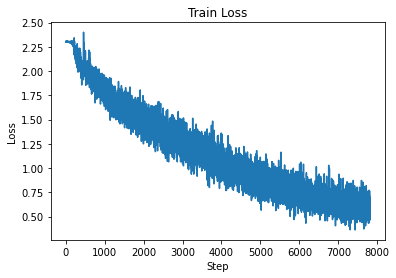

In [11]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

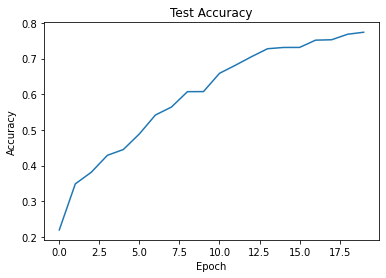

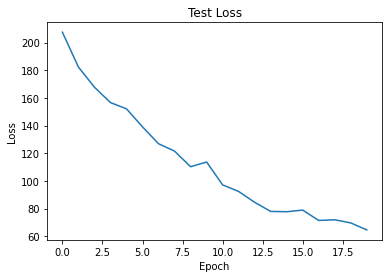

In [12]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 6.3 With BN Training

In [13]:
# ** 기본적으로 Residual Connection 은 Loss Landscape Smoothing 효과가 있음!!! **
# 참고 reference : https://arxiv.org/abs/1712.09913
print('모델 파라미터를 초기화')

cuda = True if torch.cuda.is_available() else False
if cuda:
    net = ResNet18(with_BN = True).cuda()
else:
    net = ResNet18(with_BN = True)
    
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr = learning_rate, 
                      momentum = 0.9, weight_decay = 0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수 : ', total_params)

모델 파라미터를 초기화
학습 가능한 총 파라미터 수 :  11173962


In [14]:
with_BN_train_accuracies = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[Epoch : {epoch} / {epochs}]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps), cuda)
    with_BN_train_accuracies.append(train_accuracy)
    with_BN_steps.extend(steps)
    with_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')
    
    test_accuracy, test_loss = test(net, optimizer, epoch, cuda)
    with_BN_test_accuracies.append(test_accuracy)
    with_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:2f} / Test loss = {test_loss}')

[Epoch : 0 / 20]
Train accuracy = 46.71 / Train loss = 568.7912685871124
Test accuracy = 50.100000 / Test loss = 149.87479650974274
[Epoch : 1 / 20]
Train accuracy = 65.78 / Train loss = 377.17705035209656
Test accuracy = 67.970000 / Test loss = 91.64452368021011
[Epoch : 2 / 20]
Train accuracy = 74.08 / Train loss = 290.9509983062744
Test accuracy = 75.310000 / Test loss = 73.68302661180496
[Epoch : 3 / 20]
Train accuracy = 78.77 / Train loss = 238.0373584330082
Test accuracy = 78.830000 / Test loss = 63.001729249954224
[Epoch : 4 / 20]
Train accuracy = 81.53 / Train loss = 208.57120582461357
Test accuracy = 79.370000 / Test loss = 61.60473322868347
[Epoch : 5 / 20]
Train accuracy = 83.36 / Train loss = 186.04195845127106
Test accuracy = 77.160000 / Test loss = 72.68966647982597
[Epoch : 6 / 20]
Train accuracy = 85.08 / Train loss = 168.4304623901844
Test accuracy = 77.940000 / Test loss = 66.71426117420197
[Epoch : 7 / 20]
Train accuracy = 86.30 / Train loss = 152.91691488027573
Test

## 6.4 With BN Summary

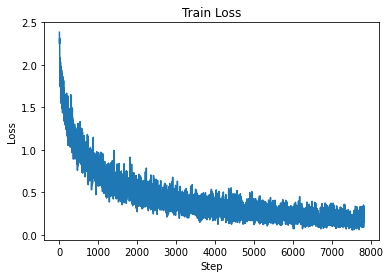

In [15]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

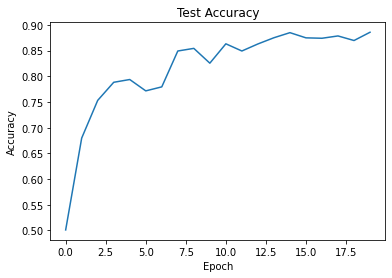

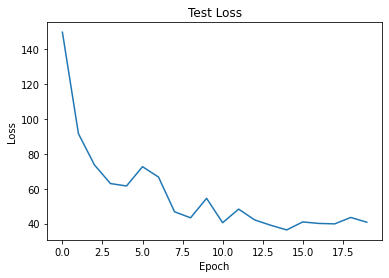

In [16]:
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 6.5 Without BN vs With BN

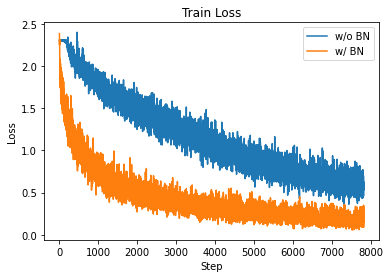

In [17]:

plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

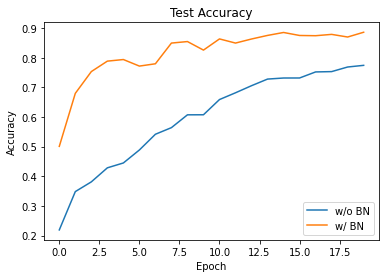

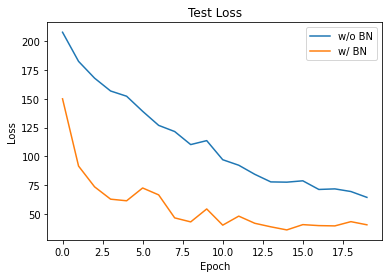

In [18]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()